In [ ]:
## Kaggle API Token 업로드 코드

from google.colab import files

# 파일 업로드 대화 상자를 띄웁니다.
print("Kaggle API Token (kaggle.json) 파일을 선택하여 업로드해주세요.")
uploaded = files.upload()

# 업로드된 파일 이름을 확인합니다.
if 'kaggle.json' in uploaded:
    print("kaggle.json 파일 업로드 완료.")

    # .kaggle 디렉토리를 생성하고 kaggle.json을 이동/복사합니다.
    # Kaggle CLI가 파일을 찾을 수 있도록 표준 위치에 저장합니다.
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # API 키 파일에 대한 권한을 설정합니다 (보안을 위해 필수).
    !chmod 600 ~/.kaggle/kaggle.json

    print("Kaggle 환경 설정 완료. 이제 !kaggle 명령어를 사용할 수 있습니다.")
else:
    print("'kaggle.json' 파일이 업로드되지 않았거나 파일명이 다릅니다.")

Kaggle API Token (kaggle.json) 파일을 선택하여 업로드해주세요.


Saving kaggle.json to kaggle.json
kaggle.json 파일 업로드 완료.
Kaggle 환경 설정 완료. 이제 !kaggle 명령어를 사용할 수 있습니다.


In [ ]:
"""
========================================
11주차 실습: 의료영상 분석 (초급)
Medical Image Analysis with Chest X-Ray
========================================

데이터셋: Kaggle Chest X-Ray Pneumonia Dataset
목표: ResNet18 Transfer Learning + Grad-CAM 기초

실습 구성:
1. 환경 설정
2. DICOM 기초 이해
3. 데이터셋 다운로드 및 탐색
4. 데이터 전처리
5. 모델 구성 (ResNet18)
6. 모델 학습
7. 성능 평가
8. Grad-CAM 시각화
"""


'\n========================================\n11주차 실습: 의료영상 분석 (초급)\nMedical Image Analysis with Chest X-Ray\n========================================\n\n데이터셋: Kaggle Chest X-Ray Pneumonia Dataset\n목표: ResNet18 Transfer Learning + Grad-CAM 기초\n\n실습 구성:\n1. 환경 설정\n2. DICOM 기초 이해\n3. 데이터셋 다운로드 및 탐색\n4. 데이터 전처리\n5. 모델 구성 (ResNet18)\n6. 모델 학습\n7. 성능 평가\n8. Grad-CAM 시각화\n'

In [ ]:
# 섹션 1: 환경 설정 및 라이브러리 설치

# 필요한 라이브러리 설치 (에러 방지를 위해 패키지 이름 수정 및 설치 명령어 분리)
# grad-cam: Grad-CAM 시각화를 위한 라이브러리 (pytorch-grad-cam 대신 사용)
# pydicom: DICOM 파일을 읽기 위한 라이브러리
# opendatasets: Kaggle 데이터셋 다운로드용

!pip install -q pydicom opendatasets
!pip install -q grad-cam # pytorch-grad-cam 대신 grad-cam 설치

# 기본 라이브러리 임포트
import os  # 파일 및 디렉토리 관리
import numpy as np  # 수치 계산
import matplotlib.pyplot as plt  # 시각화
from PIL import Image  # 이미지 처리
import torch  # PyTorch 메인 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.optim as optim  # 최적화 알고리즘
from torch.utils.data import Dataset, DataLoader  # 데이터 로딩
import torchvision.transforms as transforms  # 이미지 변환
from torchvision import models  # 사전학습된 모델
from torchvision.models import ResNet18_Weights # 최신 가중치 로드 방식
from sklearn.metrics import confusion_matrix, classification_report  # 평가 지표
import seaborn as sns  # 시각화 (confusion matrix용)
import pydicom  # DICOM 파일 읽기
# Grad-CAM 관련 라이브러리 임포트 (모듈명은 pytorch_grad_cam을 유지)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 랜덤 시드 고정 (재현 가능한 결과를 위해)
SEED = 42
torch.manual_seed(SEED)  # PyTorch 시드
np.random.seed(SEED)  # NumPy 시드
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True # 결정적 알고리즘 사용
    torch.backends.cudnn.benchmark = False   # 속도보다는 재현성 우선

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")
print(f"PyTorch 버전: {torch.__version__}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
사용 디바이스: cuda
PyTorch 버전: 2.9.0+cu126


In [ ]:
# 섹션 2: DICOM 기초 이해

# DICOM이란?
# Digital Imaging and Communications in Medicine
# 의료영상의 표준 포맷으로, 이미지 데이터와 메타데이터(환자정보, 촬영정보 등)를 포함

# 간단한 DICOM 구조 시각화
print("\nDICOM 파일 구조:")
print("┌─────────────────────┐")
print("│  DICOM File Header  │  ← 파일 식별자")
print("├─────────────────────┤")
print("│   Meta Information  │  ← 전송 구문 정보")
print("├─────────────────────┤")
print("│  Patient Info       │  ← 환자 정보")
print("│  Study Info         │  ← 검사 정보")
print("│  Series Info        │  ← 시리즈 정보")
print("│  Image Info         │  ← 영상 정보")
print("├─────────────────────┤")
print("│   Pixel Data        │  ← 실제 이미지 데이터")
print("└─────────────────────┘")

# 실제 DICOM 예제 (샘플 파일이 있다면)
print("\nDICOM 메타데이터 주요 항목:")
print("- PatientName: 환자 이름")
print("- PatientAge: 환자 나이")
print("- Modality: 촬영 방식 (X-Ray, CT, MRI 등)")
print("- WindowCenter/WindowWidth: 영상 밝기 조절 값")
print("- PixelData: 실제 이미지 픽셀 배열")


DICOM 파일 구조:
┌─────────────────────┐
│  DICOM File Header  │  ← 파일 식별자
├─────────────────────┤
│   Meta Information  │  ← 전송 구문 정보
├─────────────────────┤
│  Patient Info       │  ← 환자 정보
│  Study Info         │  ← 검사 정보
│  Series Info        │  ← 시리즈 정보
│  Image Info         │  ← 영상 정보
├─────────────────────┤
│   Pixel Data        │  ← 실제 이미지 데이터
└─────────────────────┘

DICOM 메타데이터 주요 항목:
- PatientName: 환자 이름
- PatientAge: 환자 나이
- Modality: 촬영 방식 (X-Ray, CT, MRI 등)
- WindowCenter/WindowWidth: 영상 밝기 조절 값
- PixelData: 실제 이미지 픽셀 배열


In [ ]:
# 섹션 3: 데이터셋 다운로드 및 탐색

# Kaggle API 설정 (Kaggle 계정 필요)
# Kaggle에서 API Token을 다운로드하여 업로드해야 함


# Kaggle API 설정 및 데이터셋 다운로드
try:
    # files.upload() 대신 파일이 업로드되었다고 가정하고 셸 명령 실행
    # (Colab 환경에서 블록킹 오류를 방지하기 위함)
    if os.path.exists("kaggle.json"):
        from google.colab import files # files 모듈 임포트 유지

        # Kaggle 디렉토리 생성 및 파일 이동
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

        # 데이터셋 다운로드
        !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./data

        # 압축 해제
        !unzip -o -q ./data/chest-xray-pneumonia.zip -d ./data/

        # 불필요한 파일/폴더 제거
        !rm ./data/chest-xray-pneumonia.zip
        !rm -rf ./data/__MACOSX

        print("다운로드 완료!")
        data_dir = "./data/chest_xray"
    else:
        print("'kaggle.json' 파일을 찾을 수 없습니다. 파일을 업로드해주세요.")
        data_dir = "./data/chest_xray" # 경로 변수는 설정

except Exception as e:
    print(f"다운로드 실패: {e}")
    print("   수동으로 데이터셋을 다운로드하여 업로드해주세요.")
    data_dir = "./data/chest_xray" # 실패하더라도 경로 변수는 설정



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 94% 2.17G/2.29G [00:05<00:00, 374MB/s]
100% 2.29G/2.29G [00:05<00:00, 448MB/s]
다운로드 완료!


In [ ]:
# 데이터셋 구조 확인
print("\n데이터셋 구조:")
if os.path.exists(data_dir):
    # TRAIN 디렉토리만 확인하여 경로 오류 방지
    check_dir = os.path.join(data_dir, "train")
    if os.path.exists(check_dir):
        # TRAIN, TEST 디렉토리를 중심으로 구조 출력
        for split in ['train', 'test']:
            print(f"  {split.upper()}/")
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(data_dir, split, class_name)
                if os.path.exists(class_path):
                    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
                    print(f"    {class_name}/")
                    for file in files[:3]:  # 처음 3개만 표시
                         print(f"      {file}")
                    if len(files) > 3:
                        print(f"      ... (총 {len(files)}개 파일)")


데이터셋 구조:
  TRAIN/
    NORMAL/
      NORMAL2-IM-1269-0001-0001.jpeg
      IM-0574-0001.jpeg
      NORMAL2-IM-1090-0001.jpeg
      ... (총 1341개 파일)
    PNEUMONIA/
      person418_virus_852.jpeg
      person25_bacteria_121.jpeg
      person1043_bacteria_2977.jpeg
      ... (총 3875개 파일)
  TEST/
    NORMAL/
      NORMAL2-IM-0233-0001.jpeg
      IM-0011-0001-0002.jpeg
      NORMAL2-IM-0222-0001.jpeg
      ... (총 234개 파일)
    PNEUMONIA/
      person158_bacteria_743.jpeg
      person48_virus_100.jpeg
      person100_bacteria_475.jpeg
      ... (총 390개 파일)



데이터셋 통계:
   Train - NORMAL: 1341장
   Train - PNEUMONIA: 3875장
   Test - NORMAL: 234장
   Test - PNEUMONIA: 390장

샘플 이미지 확인:


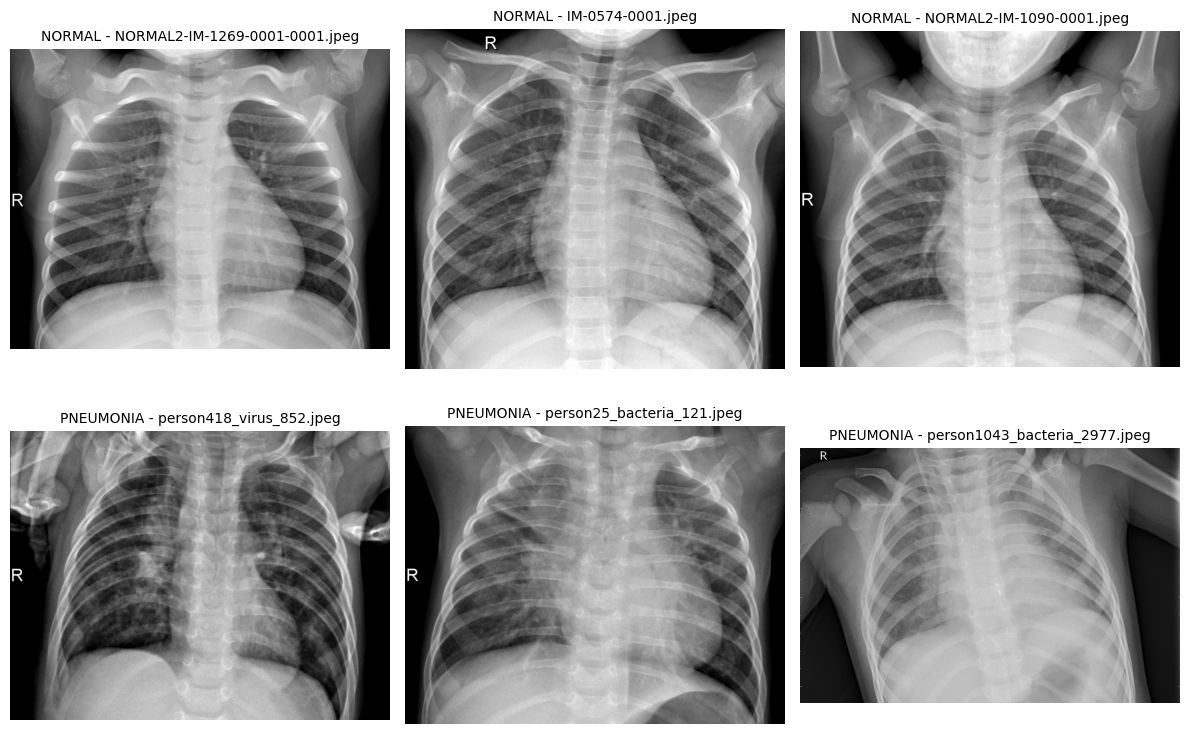

샘플 이미지가 저장되었습니다: sample_xray_images.png


In [ ]:
# 데이터셋 통계
if os.path.exists(os.path.join(data_dir, "train/NORMAL")):
    train_normal = len(os.listdir(os.path.join(data_dir, "train/NORMAL")))
    train_pneumonia = len(os.listdir(os.path.join(data_dir, "train/PNEUMONIA")))
    test_normal = len(os.listdir(os.path.join(data_dir, "test/NORMAL")))
    test_pneumonia = len(os.listdir(os.path.join(data_dir, "test/PNEUMONIA")))

    print("\n데이터셋 통계:")
    print(f"   Train - NORMAL: {train_normal}장")
    print(f"   Train - PNEUMONIA: {train_pneumonia}장")
    print(f"   Test - NORMAL: {test_normal}장")
    print(f"   Test - PNEUMONIA: {test_pneumonia}장")

    # 샘플 이미지 시각화를 위한 경로 유효성 검사
    if train_normal > 0 and train_pneumonia > 0:
        # 샘플 이미지 시각화
        print("\n샘플 이미지 확인:")
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        # Normal 샘플 3개
        normal_path = os.path.join(data_dir, "train/NORMAL")
        normal_images = [f for f in os.listdir(normal_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))][:3]
        for i, img_name in enumerate(normal_images):
            img = Image.open(os.path.join(normal_path, img_name))
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f"NORMAL - {img_name}", fontsize=10)
            axes[0, i].axis('off')

        # Pneumonia 샘플 3개
        pneumonia_path = os.path.join(data_dir, "train/PNEUMONIA")
        pneumonia_images = [f for f in os.listdir(pneumonia_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))][:3]
        for i, img_name in enumerate(pneumonia_images):
            img = Image.open(os.path.join(pneumonia_path, img_name))
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f"PNEUMONIA - {img_name}", fontsize=10)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.savefig('sample_xray_images.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("샘플 이미지가 저장되었습니다: sample_xray_images.png")
    else:
         print("\n샘플 이미지를 시각화할 데이터가 부족합니다.")

In [ ]:
# 섹션 4: 데이터 전처리 및 Dataset 클래스

# 이미지 전처리 파이프라인 정의
# ResNet18은 ImageNet으로 사전학습되었으므로 동일한 정규화 사용
print("\n이미지 전처리 설정:")
print("   - 크기 조정: 224x224 (ResNet 입력 크기)")
print("   - RGB 변환: 흑백 → 컬러 (3채널)")
print("   - 텐서 변환 및 정규화")

# ImageNet의 평균 및 표준편차 (재사용을 위해 정의)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Train 용 전처리 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.Grayscale(num_output_channels=3),  # 흑백 이미지를 컬러(RGB)로 변환
    transforms.RandomHorizontalFlip(p=0.3),  # (30% 확률로)랜덤 수평 뒤집기(좌우 반전) 데이터 증강
    transforms.RandomRotation(degrees=10),   # +- 10 도 범위 내에서 회전

    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) #ImageNet 평균값, 표준편차로 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.Grayscale(num_output_channels=3),  # 흑백 이미지를 컬러(RGB)로 변환

    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) #ImageNet 평균값, 표준편차로 정규화
])


이미지 전처리 설정:
   - 크기 조정: 224x224 (ResNet 입력 크기)
   - RGB 변환: 흑백 → 컬러 (3채널)
   - 텐서 변환 및 정규화


In [ ]:
# Custom Dataset 클래스 정의
class ChestXrayDataset(Dataset):
    """
    흉부 X-Ray 데이터셋 클래스
    NORMAL과 PNEUMONIA 두 클래스를 분류
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): 데이터 루트 디렉토리 경로
            transform: 이미지 전처리 파이프라인
        """
        self.root_dir = root_dir  # 데이터 경로
        self.transform = transform  # 전처리 함수
        self.images = []  # 이미지 경로 리스트
        self.labels = []  # 라벨 리스트

        # 클래스별 디렉토리에서 이미지 파일 경로 수집
        # 0: NORMAL, 1: PNEUMONIA
        classes = ['NORMAL', 'PNEUMONIA']
        for label, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)  # 클래스 디렉토리
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):  # 이미지 파일만
                        self.images.append(os.path.join(class_dir, img_name))  # 경로 저장
                        self.labels.append(label)  # 라벨 저장
            else:
                 pass # 경로가 없으면 무시하고 넘어감

    def __len__(self):
        """데이터셋 크기 반환"""
        return len(self.images)

    def __getitem__(self, idx):
        """
        인덱스에 해당하는 이미지와 라벨 반환
        Args:
            idx: 데이터 인덱스
        Returns:
            image: 전처리된 이미지 텐서
            label: 클래스 라벨 (0 or 1)
        """
        img_path = self.images[idx]  # 이미지 경로
        image = Image.open(img_path).convert('RGB')  # 이미지 로드 및 RGB 변환
        label = self.labels[idx]  # 라벨

        if self.transform:
            image = self.transform(image)  # 전처리 적용

        return image, label

In [ ]:
# Dataset 및 DataLoader 생성
train_dataset = ChestXrayDataset(
    root_dir = os.path.join(data_dir, "train"),
    transform=train_transform
)

test_dataset = ChestXrayDataset(
    root_dir = os.path.join(data_dir, "test"),
    transform=test_transform
)

# 데이터가 없는 경우를 대비하여 조건문 추가
if len(train_dataset) == 0:
    print("학습 데이터셋이 비어있습니다. 이후 학습 및 평가 단계를 건너뛸 수 있습니다.")

# DataLoader 생성 (배치 단위로 데이터 로딩)
batch_size = 32  # 한 번에 처리할 이미지 개수
num_workers = 2  # 병렬 처리 워커 수 (Colab 환경에 적합)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [ ]:
print(f"   Train 데이터: {len(train_dataset)}장")
print(f"   Test 데이터: {len(test_dataset)}장")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}개")
print(f"   Test batches: {len(test_loader)}개")

   Train 데이터: 5216장
   Test 데이터: 624장
   Batch size: 32
   Train batches: 163개
   Test batches: 20개


In [ ]:
# 섹션 5: 모델 구성 (ResNet18 Transfer Learning)

print("\nTransfer Learning이란?")
print("   - 대규모 데이터셋(ImageNet)으로 사전학습된 모델을 활용")
print("   - 마지막 분류층(FC)만 우리 문제에 맞게 교체")

# (사전 학습된) 모델 로드
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# 모델 구조 확인
print("\nResNet18 기본 구조:")
print(f"   - 입력: 224x224x3 RGB 이미지")
print(f"   - 출력: 1000개 클래스 (ImageNet)")

# 마지막 fc layer 교체 (1000 >> 2개 (정상, 폐렴 환자))
num_features = model.fc.in_features # fc layer 입력 특징 개수
model.fc = nn.Linear(num_features, 2)  # 2개 클래스 변경

model = model.to(device)

#수정된 모델 최종 층
# Linear(in_features=512, out_features=2, bias=True)
model.fc


Transfer Learning이란?
   - 대규모 데이터셋(ImageNet)으로 사전학습된 모델을 활용
   - 마지막 분류층(FC)만 우리 문제에 맞게 교체
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]



ResNet18 기본 구조:
   - 입력: 224x224x3 RGB 이미지
   - 출력: 1000개 클래스 (ImageNet)


Linear(in_features=512, out_features=2, bias=True)


학습 설정:
   - 손실 함수: CrossEntropyLoss
   - 옵티마이저: Adam
   - 학습률: 0.0001
   - 에폭 수: 5

학습 시작!

   Epoch [1/5], Batch [100/163], Loss: 0.0282

Epoch [1/5] 완료:
   평균 Loss: 0.1123
   정확도: 95.76%

   Epoch [2/5], Batch [100/163], Loss: 0.0594

Epoch [2/5] 완료:
   평균 Loss: 0.0576
   정확도: 97.91%

   Epoch [3/5], Batch [100/163], Loss: 0.0026

Epoch [3/5] 완료:
   평균 Loss: 0.0391
   정확도: 98.64%

   Epoch [4/5], Batch [100/163], Loss: 0.2227

Epoch [4/5] 완료:
   평균 Loss: 0.0362
   정확도: 98.73%

   Epoch [5/5], Batch [100/163], Loss: 0.0043

Epoch [5/5] 완료:
   평균 Loss: 0.0268
   정확도: 99.02%


학습 완료!


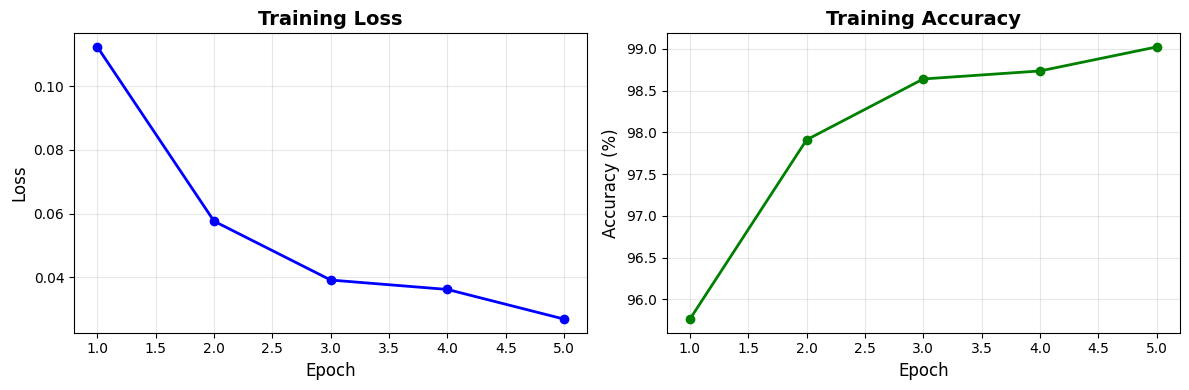

학습 곡선이 저장되었습니다: training_curves.png


In [ ]:
# 모델 학습

# 손실함수
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류용 손실함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("\n학습 설정:")
print(f"   - 손실 함수: CrossEntropyLoss")
print(f"   - 옵티마이저: Adam")
print(f"   - 학습률: 0.0001")
print(f"   - 에폭 수: 5")

# 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    """
    모델 학습 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        criterion: 손실 함수
        optimizer: 옵티마이저
        num_epochs: 학습 에폭 수
    Returns:
        train_losses: 에폭별 학습 손실
        train_accuracies: 에폭별 학습 정확도
    """
    train_losses = []  # 에폭별 손실 저장
    train_accuracies = []  # 에폭별 정확도 저장

    for epoch in range(num_epochs):
        model.train()  # 학습 모드
        running_loss = 0.0  # 현재 에폭 손실 누적
        correct = 0  # 정답 개수
        total = 0  # 전체 샘플 개수

        # 배치별 학습
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)  # 이미지를 GPU로
            labels = labels.to(device)  # 라벨을 GPU로

            # Forward pass (순전파)
            outputs = model(images)  # 모델 예측
            loss = criterion(outputs, labels)  # 손실 계산

            # Backward pass (역전파)
            optimizer.zero_grad()  # 기울기 초기화
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            # 통계 계산
            running_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs.data, 1)  # 예측 클래스
            total += labels.size(0)  # 전체 샘플 수
            correct += (predicted == labels).sum().item()  # 정답 개수

            # 100 배치마다 진행상황 출력 (데이터셋 크기 고려)
            if (batch_idx + 1) % 100 == 0:
                print(f"   Epoch [{epoch+1}/{num_epochs}], "
                      f"Batch [{batch_idx+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")

        # 에폭 통계
        epoch_loss = running_loss / len(train_loader)  # 평균 손실
        epoch_acc = 100 * correct / total  # 정확도
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"\nEpoch [{epoch+1}/{num_epochs}] 완료:")
        print(f"   평균 Loss: {epoch_loss:.4f}")
        print(f"   정확도: {epoch_acc:.2f}%\n")

    return train_losses, train_accuracies

# 모델 학습 실행 (데이터가 있을 경우에만)
if len(train_dataset) > 0:
    print("\n학습 시작!\n")
    num_epochs = 5  # 초급 실습이므로 5 에폭
    train_losses, train_accuracies = train_model(
        model, train_loader, criterion, optimizer, num_epochs
    )
    print("\n학습 완료!")

    # 학습 곡선 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss 그래프
    axes[0].plot(range(1, num_epochs+1), train_losses, 'b-o', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Accuracy 그래프
    axes[1].plot(range(1, num_epochs+1), train_accuracies, 'g-o', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("학습 곡선이 저장되었습니다: training_curves.png")
else:
    print("\n학습 데이터셋이 비어있어 학습을 건너뜁니다.")
    train_losses = []
    train_accuracies = []

In [ ]:
# 모델 평가

# 평가 함수
def evaluate_model(model, test_loader):
    """
    테스트 데이터로 모델 평가
    Args:
        model: 평가할 모델
        test_loader: 테스트 데이터 로더
    Returns:
        accuracy: 정확도
        all_labels: 실제 라벨
        all_predictions: 예측 라벨
    """
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    all_labels = []  # 실제 라벨 저장
    all_predictions = []  # 예측 라벨 저장

    with torch.no_grad():  # 기울기 계산 비활성화
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # 예측
            _, predicted = torch.max(outputs.data, 1)  # 최대값 인덱스

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # CPU로 이동하여 저장
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_predictions


테스트 데이터 평가 중...

테스트 정확도: 86.70%

 Confusion Matrix:
[[153  81]
 [  2 388]]


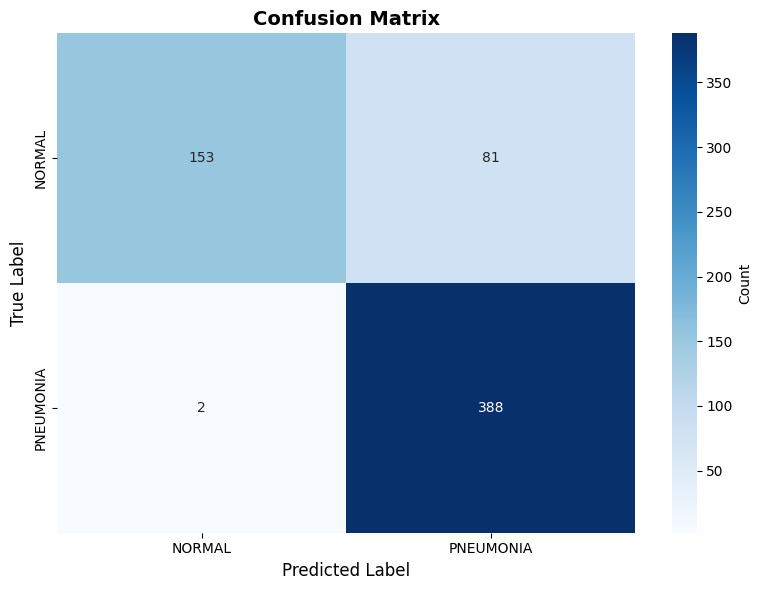

Confusion Matrix 저장: confusion_matrix.png

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.65      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.85       624
weighted avg       0.89      0.87      0.86       624



In [ ]:
# 평가 실행 (테스트 데이터가 있고, 학습이 진행되었다고 가정)
test_accuracy = 0.0
true_labels = []
pred_labels = []

if len(test_dataset) > 0 and len(train_dataset) > 0:
    print("\n테스트 데이터 평가 중...")
    test_accuracy, true_labels, pred_labels = evaluate_model(model, test_loader)
    print(f"\n테스트 정확도: {test_accuracy:.2f}%")

    # Confusion Matrix 생성
    cm = confusion_matrix(true_labels, pred_labels)
    print("\n Confusion Matrix:")
    print(cm)

    # Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'],
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Confusion Matrix 저장: confusion_matrix.png")

    # Classification Report
    print("\nClassification Report:")
    class_names = ['NORMAL', 'PNEUMONIA']
    print(classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0))
else:
    print("\n테스트 데이터셋이 비어있거나 학습이 진행되지 않아 평가를 건너뜁니다.")


Grad-CAM이란?
   - Gradient-weighted Class Activation Mapping
   - 모델이 어느 부분을 보고 판단했는지 시각화
   - 의료 AI의 신뢰성 향상에 필수

샘플 이미지 선택 중...


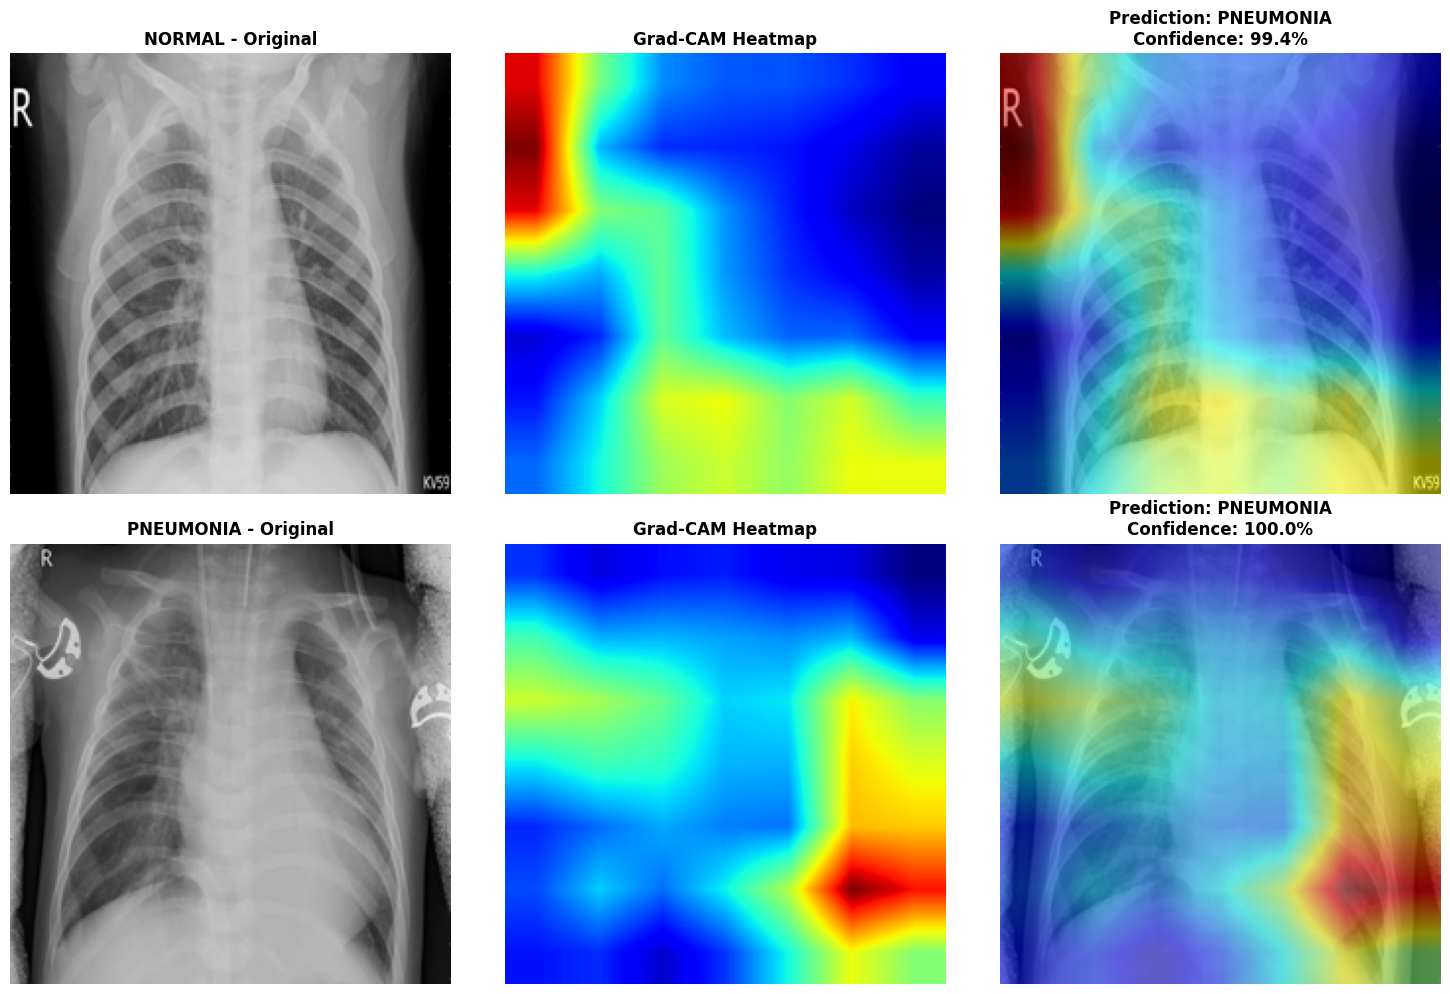

Grad-CAM 결과 저장: gradcam_results.png


In [ ]:
# 섹션 8: Grad-CAM 시각화 (XAI)


if len(test_dataset) > 0 and len(train_dataset) > 0:

    print("\nGrad-CAM이란?")
    print("   - Gradient-weighted Class Activation Mapping")
    print("   - 모델이 어느 부분을 보고 판단했는지 시각화")
    print("   - 의료 AI의 신뢰성 향상에 필수")

    # Grad-CAM 설정
    target_layers = [model.layer4[-1]]  # ResNet18의 마지막 conv layer
    grad_cam = GradCAM(model=model, target_layers=target_layers) # grad_cam 변수명으로 변경 (기존 cam과 충돌 방지)

    # 테스트 이미지 선택 (각 클래스별 1장씩)
    def get_sample_images(test_dataset, num_samples=1):
        """각 클래스에서 샘플 이미지 추출"""
        samples = {'NORMAL': [], 'PNEUMONIA': []}

        for idx in range(len(test_dataset)):
            img_tensor, label = test_dataset[idx]
            class_name = 'NORMAL' if label == 0 else 'PNEUMONIA'

            if len(samples[class_name]) < num_samples:
                # 원본 이미지도 함께 저장 (경로를 통해 로드)
                # TestDataset은 경로를 반환하지 않지만, 임시로 로드한 후 원본 경로를 찾을 수 없으므로
                # 여기서는 Dataset 클래스에서 직접 경로를 가져와야 함 (단, test_dataset은 경로를 저장하지 않음)
                # 이를 위해 임시로 test_dataset을 ChestXrayDatasetAdvanced처럼 return_path=True로 구현하는 것이 이상적이나,
                # 초급 실습의 단순성을 위해, 여기서는 경로를 직접 로드할 수 있도록 test_dataset의 내부 images 리스트를 사용합니다.

                # 주의: test_dataset이 random_split으로 생성된 경우 이 방식은 작동하지 않으나,
                # 초급 코드는 random_split을 사용하지 않으므로, images 리스트를 사용합니다.

                # 안전한 방법: Dataset 클래스 내부에 경로를 저장했는지 확인하고 사용
                if hasattr(test_dataset, 'images'):
                    img_path = test_dataset.images[idx]
                    orig_img = Image.open(img_path).convert('RGB')
                    samples[class_name].append((img_tensor, label, orig_img))

            if all(len(v) >= num_samples for v in samples.values()):
                break

        return samples

    # 샘플 이미지 가져오기
    print("\n샘플 이미지 선택 중...")
    sample_images = get_sample_images(test_dataset, num_samples=1)

    # Grad-CAM 적용 및 시각화
    # 샘플이 최소한 1개라도 있어야 시각화 진행
    if sample_images['NORMAL'] and sample_images['PNEUMONIA']:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        for row, (class_name, samples) in enumerate(sample_images.items()):
            # 각 클래스에서 첫 번째 샘플을 사용
            img_tensor, label, orig_img = samples[0]

            # 모델 예측
            model.eval()
            input_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가

            with torch.no_grad():
                output = model(input_tensor)
                pred_prob = torch.softmax(output, dim=1) # (batch_size, class)
                # (1, 10) >> 이미지 1장, 클래스 10개
                pred_class = torch.argmax(pred_prob, dim=1).item()
                confidence = pred_prob[0][pred_class].item() * 100
                # pred_prob[0] : 확률리스트 [0.1, 0.8, 0.05,...]
                # [pred_class] : 예측 클래스의 index 1

            # Grad-CAM 생성
            targets = [ClassifierOutputTarget(pred_class)]
            grayscale_cam = grad_cam(input_tensor=input_tensor, targets=targets)
            # grad_cam 계산 (1,224,224) (b,h,w) 크기의 히트맵 (0-1 범위)
            grayscale_cam = grayscale_cam[0, :]
            # 0 : batch_size >> 1개, ":" 나머지 차원 (24,24) 그대로 가져와 (224,224) (h,w)


            # 원본 이미지를 numpy 배열로 변환
            orig_img_resized = orig_img.resize((224, 224))
            rgb_img = np.array(orig_img_resized, dtype=np.float32) / 255.0
            # 0-255 범위 >> 0~1 범위로 정규화(실수 변환 후)

            # CAM 오버레이
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            # 시각화
            # 1. 원본 이미지
            axes[row, 0].imshow(orig_img_resized)
            axes[row, 0].set_title(f'{class_name} - Original', fontsize=12, fontweight='bold')
            axes[row, 0].axis('off')

            # 2. Grad-CAM Heatmap
            axes[row, 1].imshow(grayscale_cam, cmap='jet')
            axes[row, 1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
            axes[row, 1].axis('off')

            # 3. 오버레이
            axes[row, 2].imshow(cam_image)
            pred_name = 'NORMAL' if pred_class == 0 else 'PNEUMONIA'
            axes[row, 2].set_title(f'Prediction: {pred_name}\nConfidence: {confidence:.1f}%',
                                  fontsize=12, fontweight='bold')
            axes[row, 2].axis('off')

        plt.tight_layout()
        plt.savefig('gradcam_results.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Grad-CAM 결과 저장: gradcam_results.png")
    else:
        print("\nGrad-CAM 시각화를 위한 NORMAL/PNEUMONIA 샘플이 부족합니다.")

else:
    print("\n학습이 진행되지 않았거나 테스트 데이터셋이 비어있어 Grad-CAM을 건너뜁니다.")



In [ ]:
# 최종 요약

print(f"   1. 데이터셋: Chest X-Ray Pneumonia")
print(f"   2. 학습 데이터: {len(train_dataset)}장")
print(f"   3. 테스트 데이터: {len(test_dataset)}장")
print(f"   4. 모델: ResNet18 Transfer Learning")
print(f"   5. 학습 에폭: {5 if len(train_dataset) > 0 else 0}")
print(f"   6. 최종 테스트 정확도: {test_accuracy:.2f}%")
print(f"\n생성된 파일:")
if len(train_dataset) > 0:
    print(f"   - sample_xray_images.png")
    print(f"   - training_curves.png")
    print(f"   - confusion_matrix.png")
    print(f"   - gradcam_results.png")
else:
    print("   (학습이 진행되지 않아 파일이 생성되지 않았습니다.)")
print("\n다음 단계:")
print("   - 중고급 실습에서 더 고급 기법 학습")
print("   - 모델 성능 개선 실험")
print("   - 다양한 XAI 기법 탐색")


   1. 데이터셋: Chest X-Ray Pneumonia
   2. 학습 데이터: 5216장
   3. 테스트 데이터: 624장
   4. 모델: ResNet18 Transfer Learning
   5. 학습 에폭: 5
   6. 최종 테스트 정확도: 86.70%

생성된 파일:
   - sample_xray_images.png
   - training_curves.png
   - confusion_matrix.png
   - gradcam_results.png

다음 단계:
   - 중고급 실습에서 더 고급 기법 학습
   - 모델 성능 개선 실험
   - 다양한 XAI 기법 탐색


In [ ]:
# [기초 실습]
players = {1: "drwill", 2: "doosan",3:"rokey", 4:"son"}
players[1]
players[1] = "gang-in"
players

{1: 'gang-in', 2: 'doosan', 3: 'rokey', 4: 'son'}